<a href="https://colab.research.google.com/github/hector-sm/Weather-Forecast/blob/master/TimeSeriesForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [1]:
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Weather dataset**

In this routine we will use a [weather time series dataset](https://smn.conagua.gob.mx/es/observando-el-tiempo/estaciones-meteorologicas-automaticas-ema-s) recorded by the [Sistema Meteorologico Nacional](https://smn.conagua.gob.mx/) in Mexico.

This dataset contains 9 features such as air temperature, atmospheric pressure, and humidity. This were collected every 10 minutes, for the past 90 days. 

In [ ]:
# # Download dataset

# url = 'https://github.com/hector-sm/Weather-Forecast/blob/master/Data/Estacion_ESCNALCIENCIASBIOLOGICAS__90_dias.csv'
# os.mkdir(f'{os.getcwd()}/Data')
# path_to_file = tf.keras.utils.get_file(f'{os.getcwd()}/Data/Estacion_ESCNALCIENCIASBIOLOGICAS__90_dias.csv', url)

# df = pd.read_csv(path_to_file)

# date_time = pd.to_datetime(df.pop)

In [2]:
# Retrieve dataset from Google Drive

file_dir = f'{os.getcwd()}/drive/My Drive/Colab Notebooks/Data/AR-VI-REAGAN NATIONAL AIRPORT.csv'
df = pd.read_csv(file_dir)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (30,31,33,34,41,42,43,46,48,49,51,52,53,69,71,73,75,76,88,89) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Set maximum length of rows and columns for the DataFrame display
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Make a list of all the features in the original dataset
df.columns.to_list()

# List of the features of interest for our analysis
columns_of_interest = ['DATE', 'HourlyAltimeterSetting', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
                       'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 'HourlyStationPressure',
                       'HourlyVisibility', 'HourlyWindDirection', 'HourlyWindSpeed']

# Contruct a filtered dataset with only the relevant features
filtered_df = df[columns_of_interest]
filtered_df.head()

# Pick only the hourly observations
filtered_df = filtered_df[filtered_df.DATE.str.contains(":52:")]
filtered_df.head()

# Pop the date column from the filtered dataset and convert it to datetime stamps
date_time = pd.to_datetime(filtered_df.pop('DATE'), format='%Y-%m-%dT%H:%M:%S')

In [4]:
# Convert all string type columns to numeric
filtered_df['HourlyAltimeterSetting'] = pd.to_numeric(filtered_df['HourlyAltimeterSetting'], errors='coerce')
filtered_df['HourlyDewPointTemperature'] = pd.to_numeric(filtered_df['HourlyDewPointTemperature'], errors='coerce')
filtered_df['HourlyDryBulbTemperature'] = pd.to_numeric(filtered_df['HourlyDryBulbTemperature'], errors='coerce')
filtered_df['HourlyRelativeHumidity'] = pd.to_numeric(filtered_df['HourlyRelativeHumidity'], errors='coerce')
filtered_df['HourlySeaLevelPressure'] = pd.to_numeric(filtered_df['HourlySeaLevelPressure'], errors='coerce')
filtered_df['HourlyStationPressure'] = pd.to_numeric(filtered_df['HourlyStationPressure'], errors='coerce')
filtered_df['HourlyVisibility'] = pd.to_numeric(filtered_df['HourlyVisibility'], errors='coerce')
filtered_df['HourlyWindDirection'] = pd.to_numeric(filtered_df['HourlyWindDirection'], errors='coerce')
print(filtered_df.dtypes)

# Check for NaN values in each column
print(filtered_df.isnull().sum())

# Impute all NaN values with the average for each column
filtered_df = filtered_df.fillna(filtered_df.mean())
print(filtered_df.isnull().sum())

HourlyAltimeterSetting       float64
HourlyDewPointTemperature    float64
HourlyDryBulbTemperature     float64
HourlyRelativeHumidity       float64
HourlySeaLevelPressure       float64
HourlyStationPressure        float64
HourlyVisibility             float64
HourlyWindDirection          float64
HourlyWindSpeed              float64
dtype: object
HourlyAltimeterSetting        166
HourlyDewPointTemperature     181
HourlyDryBulbTemperature      156
HourlyRelativeHumidity        153
HourlySeaLevelPressure        203
HourlyStationPressure         323
HourlyVisibility              171
HourlyWindDirection          1942
HourlyWindSpeed               161
dtype: int64
HourlyAltimeterSetting       0
HourlyDewPointTemperature    0
HourlyDryBulbTemperature     0
HourlyRelativeHumidity       0
HourlySeaLevelPressure       0
HourlyStationPressure        0
HourlyVisibility             0
HourlyWindDirection          0
HourlyWindSpeed              0
dtype: int64


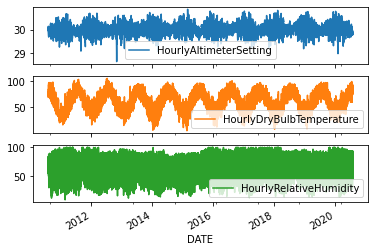

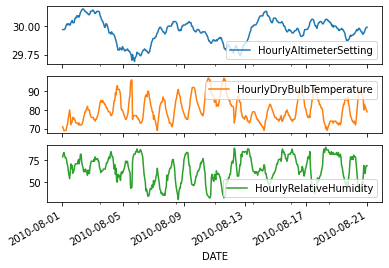

In [5]:
plot_columns = ['HourlyAltimeterSetting', 'HourlyDryBulbTemperature', 'HourlyRelativeHumidity']
plot_features = filtered_df[plot_columns]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

# Zoom in to the first 480 hours
plot_features = filtered_df[plot_columns][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [6]:
# Take a look at the statistics of the dataset:
filtered_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
HourlyAltimeterSetting,87795.0,30.055086,0.217158,28.64,29.92,30.05,30.19,30.88
HourlyDewPointTemperature,87795.0,45.796676,19.059769,-15.00,31.00,48.00,63.00,81.00
HourlyDryBulbTemperature,87795.0,59.704652,17.823191,6.00,45.00,60.00,75.00,105.00
HourlyRelativeHumidity,87795.0,62.909461,18.905887,9.00,48.00,63.00,79.00,100.00
HourlySeaLevelPressure,87795.0,30.052511,0.216926,28.63,29.91,30.05,30.19,30.88
HourlyStationPressure,87795.0,29.985218,0.216914,28.57,29.85,29.98,30.12,30.81
HourlyVisibility,87795.0,9.504899,1.616921,0.00,10.00,10.00,10.00,10.00
HourlyWindDirection,87795.0,183.706685,112.605193,0.00,80.00,190.00,290.00,360.00
HourlyWindSpeed,87795.0,8.370301,5.023405,0.00,5.00,8.00,11.00,44.00


## Feature engineering

The last two columns of the data, HourlyWindDirection, gives the wind direction in units of degrees. Angles do not make good model inputs, 360 and 0 should be close to each other, and wrap around smoothly.

Text(0, 0.5, 'Wind Velocity [m/s]')

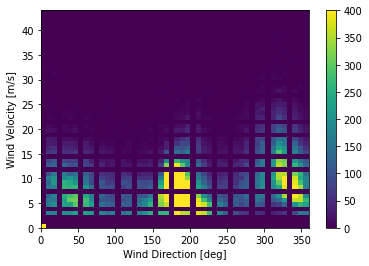

In [7]:
# Feature engineering

plt.hist2d(filtered_df['HourlyWindDirection'], filtered_df['HourlyWindSpeed'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

(-29.544232590366242,
 38.10511776651529,
 -34.76862696907861,
 31.949549106720887)

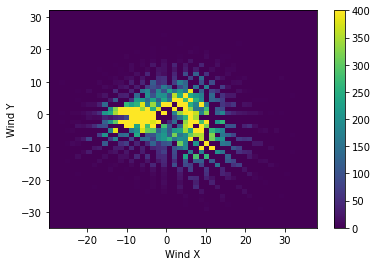

In [8]:
WindSpeed = filtered_df.pop('HourlyWindSpeed')
WindDirRadians = filtered_df.pop('HourlyWindDirection') * (np.pi/180)

# Calculate the wind x and y components.
filtered_df['WindCompX'] = WindSpeed*np.cos(WindDirRadians)
filtered_df['WindCompY'] = WindSpeed*np.sin(WindDirRadians)

plt.hist2d(filtered_df['WindCompX'], filtered_df['WindCompY'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X')
plt.ylabel('Wind Y')
ax = plt.gca()
ax.axis('tight')

In [9]:
# Time
timestamp_s = date_time.map(datetime.datetime.timestamp)

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use sin and cos to convert the time to clear "Time of day" and "Time of year" signals:

Text(0.5, 1.0, 'Time of day signal')

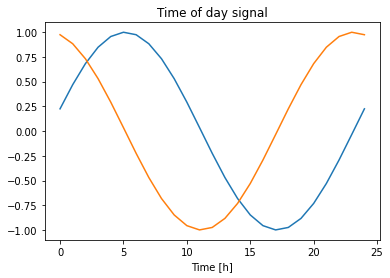

In [11]:
day = 24*60*60
year = (365.2425)*day

filtered_df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
filtered_df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
filtered_df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
filtered_df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(filtered_df['Day sin'])[:25])
plt.plot(np.array(filtered_df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

## Split the data

We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [15]:
column_indices = {name: i for i, name in enumerate(filtered_df.columns)}

n = len(filtered_df)
train_df = filtered_df[0:int(n*0.7)]
val_df = filtered_df[int(n*0.7):int(n*0.9)]
test_df = filtered_df[int(n*0.9):]

num_features = filtered_df.shape[1]

# Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

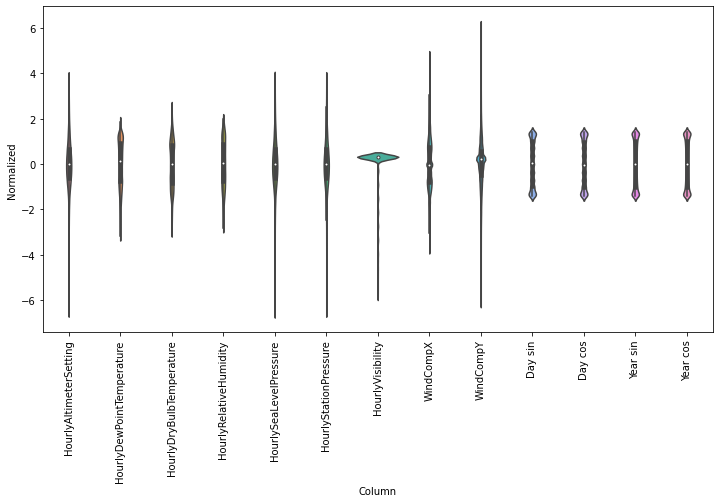

In [16]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (filtered_df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(filtered_df.keys(), rotation=90)

## Data windowing
The models will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:

1. The width (number of time steps) of the input and label windows
2. The time offset between them.
3. Which features are used as inputs, labels, or both.

1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the train, eval, and test dataframes as input. These will be converted to `tf.data.Datasets` of windows later.

In [17]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [26]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['HourlyDryBulbTemperature'])
print(w1)

w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['HourlyDryBulbTemperature'])
print(w2)

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['HourlyDryBulbTemperature']
Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['HourlyDryBulbTemperature']


2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

In [24]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [27]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 13)
Inputs shape: (3, 6, 13)
labels shape: (3, 1, 1)


Typically, data in TensorFlow is packed into arrays where the outermost index is across examples ("batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of 2, 7-timestep windows, with 13 features at each time step. It split them into a batch of 6-timestep, 13 feature inputs, and a 1-timestep 1-feature label. The label only has one feature because the WindowGenerator was initialized with label_columns=['HourlyDryBulbTemperature'].

3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [28]:
w2.example = example_inputs, example_labels

In [29]:
def plot(self, model=None, plot_col='HourlyDryBulbTemperature', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

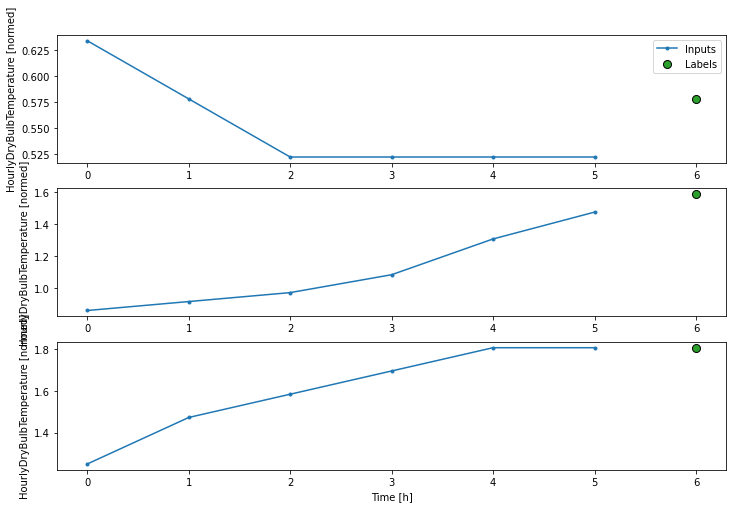

In [31]:
# This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

w2.plot(plot_col='HourlyDryBulbTemperature')

4. Create tf.data.Datasets